# Deep Learning HW1: Logistic Regression using Feed Forward Networks


## Part 1: (Binary Classification)  


#### Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

Mounted at /content/drive


#### Loading and Preparing Data for Analysis

Here, we load the dataset and ensure it is properly structured for further analysis:

1. **Loading Column Names:** The column names are extracted from `colums.txt`, excluding the last line temporarily, and cleaned by taking only the part before the colon (:). The target column is added manually.

2. **Reading the Datasets:** The training and testing datasets (`part1_train.csv` and `part1_test.csv`) are loaded with the processed column names for clarity and organization.

3. **Verifying Data:** The first few rows of each dataset are displayed to confirm that the files were loaded correctly and the structure aligns with expectations.

In [2]:
data_dir = '/content/drive/MyDrive/HW1_data'

# Load and process column names from colums.txt
column_names = []
with open(f"{data_dir}/colums.txt", "r") as f:
    lines = f.readlines()
    for line in lines[:-1]:  # Exclude the last line for now
        column_name = line.split(":")[0].strip()  # Extract column name before':'
        column_names.append(column_name)

# Add the target column explicitly
column_names.append("target")

# Load the datasets with the column names
train_data = pd.read_csv(f"{data_dir}/part1_train.csv", header=None, names=column_names)
test_data = pd.read_csv(f"{data_dir}/part1_test.csv", header=None, names=column_names)

# Preview the first five rows of each dataset
print("Training Data:")
print(train_data.head())

print("\nTesting Data:")
print(test_data.head())

Training Data:
   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  target  
0          2174             0              40   Unite

#### Visualizing Target Variable Distribution

This step analyzes the distribution of the target variable in the training dataset by calculating the percentage of each income category (`<=50K` and `>50K`). The results are printed for clarity and visualized using a bar chart.

Income Distribution in Training Data:
<=50K: 75.92%
>50K: 24.08%


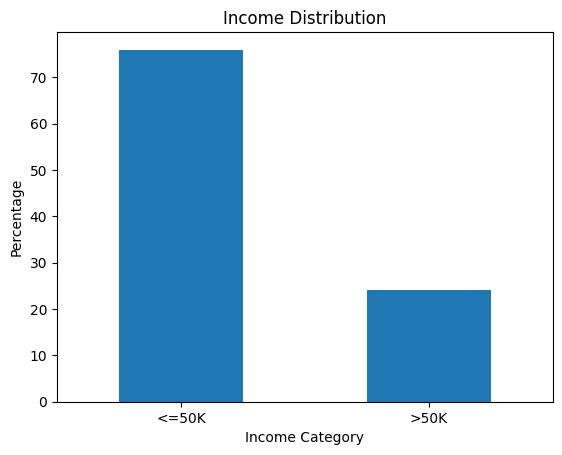

In [3]:
# Check the distribution of the target variable in the training dataset
income_distribution = train_data['target'].value_counts(normalize=True) * 100
print("Income Distribution in Training Data:")

income_distribution.index = income_distribution.index.str.strip()
print(f"<=50K: {income_distribution['<=50K']:.2f}%")
print(f">50K: {income_distribution['>50K']:.2f}%")

# Plot the distribution
income_distribution.plot(kind='bar', title="Income Distribution")
plt.xlabel("Income Category")
plt.ylabel("Percentage")
plt.xticks([0, 1], ["<=50K", ">50K"], rotation=0)
plt.show()


#### Data Preprocessing

This step involves preparing the data for model training by handling missing values, encoding categorical variables, scaling numerical features, and converting the data into tensors for PyTorch:


1. Missing values, represented by `'?'`, are replaced with `NaN`, and rows with missing data are removed from both training and testing datasets.

2. A `ColumnTransformer` is defined to preprocess the data: categorical columns are encoded using one-hot encoding, while numerical columns are scaled.

3. The target variable is mapped to binary values (`<=50K` as 0, `>50K` as 1) for consistency.

4. The data is split into training and validation sets, and the processed features and targets are converted into PyTorch tensors, ready for model input.

In [4]:
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation',
                       'relationship', 'race', 'sex', 'native-country']

numeric_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Replace '?' with NaN
for col in categorical_columns:
    train_data[col] = train_data[col].replace(' ?', np.nan)
    test_data[col] = test_data[col].replace(' ?', np.nan)

# Remove rows with missing data
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# Check for missing values
missing_train = train_data.isnull().sum().sum()
if missing_train > 0:
    print(f"Missing values in training data: {missing_train}")
else:
    print("No missing values in training data.")

missing_test = test_data.isnull().sum().sum()
if missing_test > 0:
    print(f"Missing values in test data: {missing_test}")
else:
    print("No missing values in test data.")


# Define preprocessing for categorical and numeric data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ]
)

X = train_data.drop(columns=['target'])  # Features
y = train_data['target']  # Target

# Map the target values in the entire dataset
y = y.map({' <=50K': 0, ' >50K': 1})

# Preprocess the training data
X_encoded = preprocessor.fit_transform(X)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.toarray(), dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

print("X_train_tensor shape:", X_train_tensor.shape)
print("X_val_tensor shape:", X_val_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("y_val_tensor shape:", y_val_tensor.shape)


No missing values in training data.
No missing values in test data.
X_train_tensor shape: torch.Size([24129, 104])
X_val_tensor shape: torch.Size([6033, 104])
y_train_tensor shape: torch.Size([24129, 1])
y_val_tensor shape: torch.Size([6033, 1])


#### Building, Training, and Evaluating a Feedforward Neural Network

In this step, we define, train, and evaluate a feedforward neural network for predicting income categories:

- Model Definition: A custom PyTorch model `(IncomeModel)` is defined with three fully connected layers and ReLU activations. Dropout layers are included to reduce overfitting, and the final output layer uses a Sigmoid activation for binary classification.

- Initialization: The model is initialized with the number of input features determined by the training data. Binary Cross-Entropy Loss `(BCELoss)` is chosen as the loss function, and the Adam optimizer is used for parameter updates.

- Training Loop: Over 50 epochs:

  - The model is trained using the training data with forward and backward passes, computing the loss and updating weights.
  - Binary predictions are made by thresholding probabilities at 0.5, and training accuracy is calculated.

- Validation: At each epoch, the model's performance is evaluated on the validation dataset, recording validation loss and accuracy.

- Progress Reporting: Training and validation metrics are printed every 10 epochs to monitor the model's learning progress.

In [5]:
# Define the model
class IncomeModel(nn.Module):
    def __init__(self, input_dim):
        super(IncomeModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # Hidden layer 1
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(128, 64)        # Hidden layer 2
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(64, 1)         # Output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize the model
input_dim = X_train_tensor.shape[1]   # Number of input features
model = IncomeModel(input_dim)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()  # Set the model to training mode

    # Forward pass
    outputs = model(X_train_tensor).view(-1)
    loss = criterion(outputs, y_train_tensor.view(-1))
    train_losses.append(loss.item())  # Store training loss

    train_predictions = (outputs >= 0.5).float()  # Convert probabilities to binary
    train_accuracy = (train_predictions == y_train_tensor.view(-1)).float().mean().item()
    train_accuracies.append(train_accuracy)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation step
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_val_tensor).view(-1)  # Ensure 1D output
        val_loss = criterion(val_outputs, y_val_tensor.view(-1))  # Calculate validation loss
        val_losses.append(val_loss.item())  # Store validation loss

        val_predictions = (val_outputs >= 0.5).float()
        val_accuracy = (val_predictions == y_val_tensor.view(-1)).float().mean().item()
        val_accuracies.append(val_accuracy)  # Store validation accuracy


    print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")


# torch.save(model.state_dict(), "FeedForwardNN_model.pth")
# print("Model saved!")


Epoch 1/50, Train Loss: 0.6667, Train Accuracy: 0.7530, Val Loss: 0.5998, Val Accuracy: 0.7464
Epoch 2/50, Train Loss: 0.5968, Train Accuracy: 0.7524, Val Loss: 0.5152, Val Accuracy: 0.7469
Epoch 3/50, Train Loss: 0.5140, Train Accuracy: 0.7531, Val Loss: 0.4618, Val Accuracy: 0.7515
Epoch 4/50, Train Loss: 0.4620, Train Accuracy: 0.7582, Val Loss: 0.4162, Val Accuracy: 0.7790
Epoch 5/50, Train Loss: 0.4161, Train Accuracy: 0.7832, Val Loss: 0.3719, Val Accuracy: 0.8301
Epoch 6/50, Train Loss: 0.3746, Train Accuracy: 0.8198, Val Loss: 0.3588, Val Accuracy: 0.8349
Epoch 7/50, Train Loss: 0.3617, Train Accuracy: 0.8288, Val Loss: 0.3622, Val Accuracy: 0.8134
Epoch 8/50, Train Loss: 0.3662, Train Accuracy: 0.8148, Val Loss: 0.3610, Val Accuracy: 0.8091
Epoch 9/50, Train Loss: 0.3627, Train Accuracy: 0.8118, Val Loss: 0.3594, Val Accuracy: 0.8210
Epoch 10/50, Train Loss: 0.3580, Train Accuracy: 0.8217, Val Loss: 0.3623, Val Accuracy: 0.8329
Epoch 11/50, Train Loss: 0.3577, Train Accuracy: 

#### Visualizing Model Performance

This step visualizes the training and validation loss and accuracy over the epochs to evaluate the model's learning process.

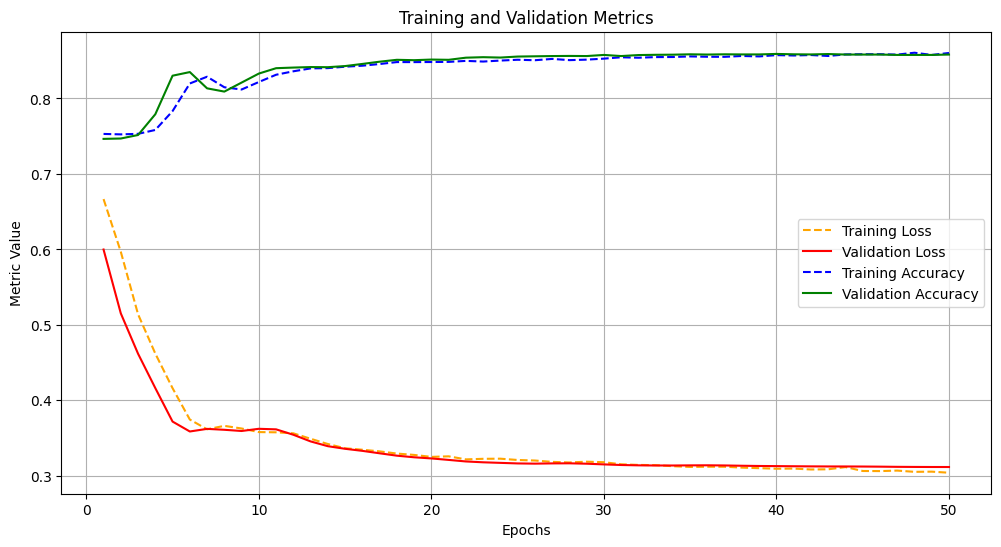

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", linestyle="--", color="orange")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", linestyle="-", color="red")
plt.plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy", linestyle="--", color="blue")
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy", linestyle="-", color="green")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.title("Training and Validation Metrics")
plt.legend()
plt.grid()
plt.show()


#### Model Summary

Here, we print the total trainable parameters and the model's structure to, along with key hyperparameters like the learning rate, epochs, and dropout rate for transparency.

In [7]:
# Calculate total trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")

# Report model structure
print("Model Structure:")
print(model)

# Report hyperparameters
print("Hyperparameters:")
print(f"Learning Rate: {0.01}")
print(f"Number of Epochs: {epochs}")
# print(f"Batch Size: {64}")
print(f"Dropout Rate: {0.3}")

Total Trainable Parameters: 21761
Model Structure:
IncomeModel(
  (fc1): Linear(in_features=104, out_features=128, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Hyperparameters:
Learning Rate: 0.01
Number of Epochs: 50
Dropout Rate: 0.3


#### Evaluating Model Performance on Test Data

Here, we evaluate the model's performance on the test dataset. The target variable is preprocessed, and the features are encoded to match the training data format.

In [9]:
# Test Data Evaluation
test_data['target'] = test_data['target'].str.strip().str.replace('.', '', regex=False)
X_test = test_data.drop(columns=['target'])
y_test = test_data['target'].map({'<=50K': 0, '>50K': 1})

X_test_encoded = preprocessor.transform(X_test)
X_test_tensor = torch.tensor(X_test_encoded.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    test_outputs = model(X_test_tensor).view(-1)
    test_predictions = (test_outputs >= 0.5).float()
    test_accuracy = (test_predictions == y_test_tensor.view(-1)).float().mean().item()
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8515


## Part 2: (Multi Class Classification)


#### Import Libraries

In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import matplotlib.pyplot as plt

 #### Load the FashionMNIST Dataset
 we load FashionMNIST dataset using `torchvision.datasets` and we print some information to confirm that the FashionMNIST dataset loaded correctly.

In [11]:
# Define transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Image size: {train_dataset[0][0].shape}")
print(f"Number of categories: {len(train_dataset.classes)}")
print(f"Categories: {train_dataset.classes}")


100%|██████████| 26.4M/26.4M [00:02<00:00, 13.1MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.85MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 9.55MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Number of training samples: 60000
Number of test samples: 10000
Image size: torch.Size([1, 28, 28])
Number of categories: 10
Categories: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


#### Split the Dataset into Training, Validation, and Test Sets

we split the training data into:

- Training Set (80% of the training samples)
- Validation Set (20% of the training samples)

and create DataLoaders for batch training.

In [12]:
# Define the split sizes
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the sizes of the datasets
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 48000
Validation set size: 12000
Test set size: 10000


#### Network 1

In this cell, we implement Network 1, a 2-layer neural network designed for 4-category classification.<br>
First, we filter the dataset to include only the first 4 categories and create DataLoaders for training, validation, and testing. The network architecture is defined to maps 784 input features to 4 output classes. <br>
We set up the CrossEntropyLoss as the loss function and the Adam optimizer with a learning rate of 0.01 and we train the network for 20 epochs.


In [13]:
# Filter function to include only the first 4 classes
def filter_first_4(dataset):
    indices = [i for i, (img, label) in enumerate(dataset) if label < 4]
    return torch.utils.data.Subset(dataset, indices)

# Filter the datasets
train_dataset_4 = filter_first_4(train_dataset)
val_dataset_4 = filter_first_4(val_dataset)
test_dataset_4 = filter_first_4(test_dataset)

# Create DataLoaders for the filtered datasets
train_loader_4 = DataLoader(train_dataset_4, batch_size=batch_size, shuffle=True)
val_loader_4 = DataLoader(val_dataset_4, batch_size=batch_size, shuffle=False)
test_loader_4 = DataLoader(test_dataset_4, batch_size=batch_size, shuffle=False)


print(f"Filtered training set size: {len(train_dataset_4)}")
print(f"Filtered validation set size: {len(val_dataset_4)}")
print(f"Filtered test set size: {len(test_dataset_4)}")


# Define Network 1
class Network1(nn.Module):
    def __init__(self):
        super(Network1, self).__init__()
        self.fc1 = nn.Linear(784, 4)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        return x

# Instantiate the network and move it to the correct device
model1 = Network1()
# Count the parameters
total_params = sum(p.numel() for p in model1.parameters())
print(f"Total parameters in Network 1: {total_params}")
print(model1)

# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
# Print a summary of the setup
print("Loss function: CrossEntropyLoss")
print(f"Optimizer: Adam (Learning Rate: 0.01)")

num_epochs = 20

# Initialize lists to track metrics
train_loss_1_history = []
val_loss_1_history = []
train_accuracy_1_history = []
val_accuracy_1_history = []


# Training Loop
for epoch in range(num_epochs):
    # Set model to training mode
    model1.train()
    running_loss_1 = 0.0
    correct_1 = 0
    total_1 = 0

    # Training phase
    for inputs, labels in train_loader_4:
        # Forward pass
        outputs = model1(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and calculate accuracy
        running_loss_1 += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_1 += labels.size(0)
        correct_1 += predicted.eq(labels).sum().item()

    # Calculate epoch training loss and accuracy
    train_loss_1 = running_loss_1 / len(train_loader_4.dataset)
    train_accuracy_1 = 100.0 * correct_1 / total_1

    # Validation phase
    model1.eval()
    val_loss_1 = 0.0
    val_correct_1 = 0
    val_total_1 = 0
    with torch.no_grad():
        for inputs, labels in val_loader_4:
            # Forward pass
            outputs = model1(inputs)
            loss = criterion(outputs, labels)

            # Accumulate validation loss and calculate accuracy
            val_loss_1 += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total_1 += labels.size(0)
            val_correct_1 += predicted.eq(labels).sum().item()

    val_loss_1 = val_loss_1 / len(val_loader_4.dataset)
    val_accuracy_1 = 100.0 * val_correct_1 / val_total_1

    train_loss_1_history.append(train_loss_1)
    val_loss_1_history.append(val_loss_1)
    train_accuracy_1_history.append(train_accuracy_1)
    val_accuracy_1_history.append(val_accuracy_1)

    # Print epoch results
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss_1:.4f}, Training Accuracy: {train_accuracy_1:.2f}%, Validation Loss: {val_loss_1:.4f}, Validation Accuracy: {val_accuracy_1:.2f}%")



Filtered training set size: 19225
Filtered validation set size: 4775
Filtered test set size: 4000
Total parameters in Network 1: 3140
Network1(
  (fc1): Linear(in_features=784, out_features=4, bias=True)
)
Loss function: CrossEntropyLoss
Optimizer: Adam (Learning Rate: 0.01)
Epoch [1/20], Training Loss: 0.3175, Training Accuracy: 90.44%, Validation Loss: 0.2507, Validation Accuracy: 92.44%
Epoch [2/20], Training Loss: 0.2622, Training Accuracy: 91.97%, Validation Loss: 0.2542, Validation Accuracy: 92.90%
Epoch [3/20], Training Loss: 0.2894, Training Accuracy: 91.89%, Validation Loss: 0.3152, Validation Accuracy: 92.29%
Epoch [4/20], Training Loss: 0.2753, Training Accuracy: 92.42%, Validation Loss: 0.2580, Validation Accuracy: 92.77%
Epoch [5/20], Training Loss: 0.2686, Training Accuracy: 92.17%, Validation Loss: 0.3414, Validation Accuracy: 91.29%
Epoch [6/20], Training Loss: 0.2606, Training Accuracy: 92.79%, Validation Loss: 0.3007, Validation Accuracy: 91.90%
Epoch [7/20], Training

Test Evaluation for Network 1

In [29]:
# Set the model to evaluation mode
model1.eval()
test_accuracy_history1 = []

# Initialize variables for test loss and accuracy
test_loss_1 = 0.0
test_correct_1 = 0
test_total_1 = 0

# Disable gradient calculation during evaluation
with torch.no_grad():
    for inputs, labels in test_loader_4:
        # Forward pass
        outputs = model1(inputs)
        loss = criterion(outputs, labels)

        # Accumulate test loss
        test_loss_1 += loss.item() * inputs.size(0)

        # Calculate accuracy
        _, predicted = outputs.max(1)
        test_total_1 += labels.size(0)
        test_correct_1 += predicted.eq(labels).sum().item()

# Calculate average test loss and accuracy
test_loss_1 = test_loss_1 / len(test_loader_4.dataset)
test_accuracy_1 = 100.0 * test_correct_1 / test_total_1
test_accuracy_history1.append(test_accuracy_1)

# Print the results
print(f"Test Loss (Network 1): {test_loss_1:.4f}")
print(f"Test Accuracy (Network 1): {test_accuracy_1:.2f}%")


Test Loss (Network 1): 0.3507
Test Accuracy (Network 1): 91.30%


#### Network 2
In this cell, we define and train Network 2 for 10-category classification.<br>
The architecture consists of 4 fully connected layers with ReLU activation and dropout regularization, ensuring the total number of parameters remains under 60k.<br>
We initialize the model, set up the optimizer (Adam) and loss function (CrossEntropyLoss), and train the network for 20 epochs.<br>


In [23]:
class Network2(nn.Module):
    def __init__(self):
        super(Network2, self).__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        self.relu = nn.ReLU()          # Activation Function
        self.dropout = nn.Dropout(0.1) # Dropout Regularization

    def forward(self, x):
        x = x.view(-1, 784)            # Flatten the input
        x = self.relu(self.fc1(x))     # Layer 1
        x = self.dropout(x)            # Dropout after Layer 1
        x = self.relu(self.fc2(x))     # Layer 2
        x = self.dropout(x)            # Dropout after Layer 2
        x = self.fc3(x)                # Output Layer
        return x

# Instantiate Network 2
model2 = Network2()
total_params = sum(p.numel() for p in model2.parameters())
print(f"Total parameters in Network 1: {total_params}")
print(model2)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)

# Training Parameters
num_epochs = 20  # Adjust as needed
batch_size = 64  # Keep consistent with Network 1

# Initialize lists to track metrics
train_loss_2_history = []
val_loss_2_history = []
train_accuracy_2_history = []
val_accuracy_2_history = []

# Training Loop
for epoch in range(num_epochs):
    # Set model to training mode
    model2.train()
    running_loss_2 = 0.0
    correct_2 = 0
    total_2 = 0

    # Training phase
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model2(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and calculate accuracy
        running_loss_2 += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total_2 += labels.size(0)
        correct_2 += predicted.eq(labels).sum().item()

    # Calculate epoch training loss and accuracy
    train_loss_2 = running_loss_2 / len(train_loader.dataset)
    train_accuracy_2 = 100.0 * correct_2 / total_2

    # Validation phase
    model2.eval()
    val_loss_2 = 0.0
    val_correct_2 = 0
    val_total_2 = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Forward pass
            outputs = model2(inputs)
            loss = criterion(outputs, labels)

            # Accumulate validation loss and calculate accuracy
            val_loss_2 += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total_2 += labels.size(0)
            val_correct_2 += predicted.eq(labels).sum().item()

    val_loss_2 = val_loss_2 / len(val_loader.dataset)
    val_accuracy_2 = 100.0 * val_correct_2 / val_total_2

    train_loss_2_history.append(train_loss_2)
    val_loss_2_history.append(val_loss_2)
    train_accuracy_2_history.append(train_accuracy_2)
    val_accuracy_2_history.append(val_accuracy_2)

    # Print epoch results
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss_2:.4f}, Training Accuracy: {train_accuracy_2:.2f}%, Validation Loss: {val_loss_2:.4f}, Validation Accuracy: {val_accuracy_2:.2f}%")


Total parameters in Network 1: 52650
Network2(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)
Epoch [1/20], Training Loss: 0.6528, Training Accuracy: 76.35%, Validation Loss: 0.5108, Validation Accuracy: 81.10%
Epoch [2/20], Training Loss: 0.5441, Training Accuracy: 80.64%, Validation Loss: 0.4741, Validation Accuracy: 83.31%
Epoch [3/20], Training Loss: 0.5269, Training Accuracy: 81.40%, Validation Loss: 0.4945, Validation Accuracy: 82.31%
Epoch [4/20], Training Loss: 0.5047, Training Accuracy: 82.11%, Validation Loss: 0.4541, Validation Accuracy: 84.16%
Epoch [5/20], Training Loss: 0.5088, Training Accuracy: 82.24%, Validation Loss: 0.4791, Validation Accuracy: 82.89%
Epoch [6/20], Training Loss: 0.4979, Training Accuracy: 82.61%, Validation Loss: 0.4866, Validation Accuracy: 82.95%
Epoch [7

Test Evaluation for Network 2

In [30]:
# Set the model to evaluation mode
model2.eval()

# Initialize variables for test loss and accuracy
test_loss_2 = 0.0
test_correct_2 = 0
test_total_2 = 0

# Disable gradient calculation during evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model2(inputs)
        loss = criterion(outputs, labels)

        # Accumulate test loss
        test_loss_2 += loss.item() * inputs.size(0)

        # Calculate accuracy
        _, predicted = outputs.max(1)
        test_total_2 += labels.size(0)
        test_correct_2 += predicted.eq(labels).sum().item()

# Calculate average test loss and accuracy
test_loss_2 = test_loss_2 / len(test_loader.dataset)
test_accuracy_2 = 100.0 * test_correct_2 / test_total_2

# Print the results
print(f"Test Loss (Network 2): {test_loss_2:.4f}")
print(f"Test Accuracy (Network 2): {test_accuracy_2:.2f}%")

# torch.save(model2.state_dict(), "network2.pth")
# print("Model saved!")


Test Loss (Network 2): 0.4832
Test Accuracy (Network 2): 84.58%


#### Plotting and Comparing Metrics for both Networks

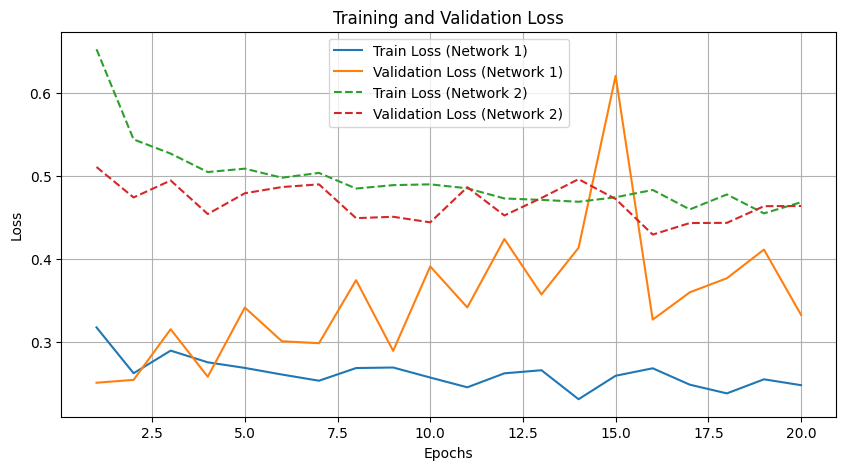

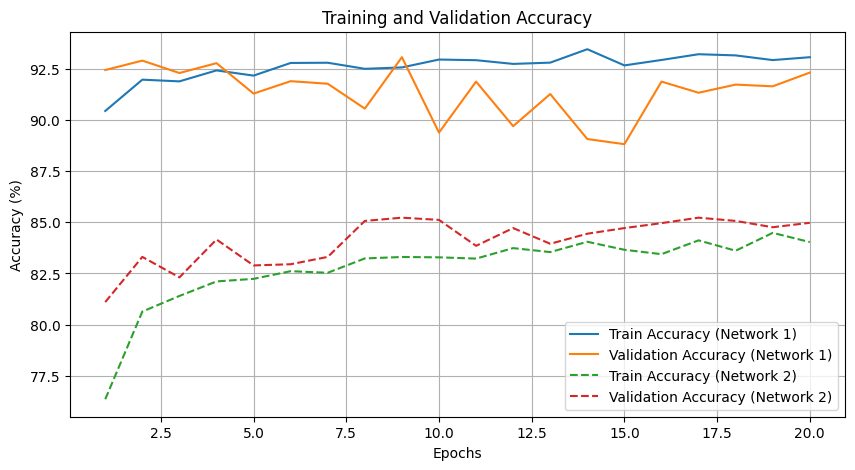

In [31]:
epochs = range(1, num_epochs + 1)
# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_1_history, label='Train Loss (Network 1)')
plt.plot(epochs, val_loss_1_history, label='Validation Loss (Network 1)')
plt.plot(epochs, train_loss_2_history, label='Train Loss (Network 2)', linestyle='--')
plt.plot(epochs, val_loss_2_history, label='Validation Loss (Network 2)', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

print("\n")
# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy_1_history, label='Train Accuracy (Network 1)')
plt.plot(epochs, val_accuracy_1_history, label='Validation Accuracy (Network 1)')
plt.plot(epochs, train_accuracy_2_history, label='Train Accuracy (Network 2)', linestyle='--')
plt.plot(epochs, val_accuracy_2_history, label='Validation Accuracy (Network 2)', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


###Analysis of the Plots
---

For the Training and Validation Loss plot:

- Network 1: The training and validation loss decreased steadily and reached low values, showing that the model learned the task effectively. There was very little difference between the two losses, which means the model did not overfit and generalized well.

- Network 2: Both the training and validation losses also decreased, but they stayed higher compared to Network 1. There was a bit more fluctuation in the validation loss, which could mean the model struggled slightly more with the task of classifying all 10 categories.


For the Training and Validation Accuracy plot:

- Network 1: The training and validation accuracy were very close, reaching around 93%-94%. This indicates that Network 1 performed very well for its simpler task of classifying 4 categories.

- Network 2: The training accuracy stabilized around 84%-85%, and the validation accuracy was slightly lower at around 85%-87%. This shows that the model had more difficulty handling the more complex task of classifying 10 categories.


Overall, Network 1 performed better because its task was simpler, while Network 2 faced more challenges due to the higher number of categories.


## Summary

#### Network Architectures:
1. Network 1:
  - Two layers: 784 -> 4
  - Total parameters: 3140, well within the 50k limit.
  - Regularization: Dropout (20%).
<br><br>

2. Network 2:
  - Four layers: 784 -> 64 -> 32 -> 10
  - Total parameters: 52650, well within the 60k limit.
  - Regularization: Dropout (20%).
---

#### Training Results:
1. Network 1:

  - Training Accuracy: ~93.4%
  - Validation Accuracy: ~94.2%
  - Loss stabilized at low values with minimal overfitting.
<br><br>

2. Network 2:

  - Training Accuracy: ~81.2%
  - Validation Accuracy: ~83.8%
  - Loss was higher compared to Network 1, with slight fluctuations in validation loss, indicating challenges with generalization for the more complex 10-category classification.
---

#### Test Results:
1. Network 1:
  - Test Accuracy: 91.30%
  - The model generalized well to unseen data, consistent with its validation performance.
2. Network 2:
  - Test Accuracy: 84.58%
  - Performance on the test set was close to the validation accuracy, showing reasonable generalization despite the more complex task.

---

#### Conclusion:
- Network 1 demonstrated high accuracy and generalization for the simpler task of 4-category classification.

- Network 2 achieved reasonable performance for the more challenging 10-category task, but its accuracy and loss were lower/higher, respectively, compared to Network 1.